In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Add src directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the aggregation function from utils script
from src.utils import aggregate_interview_sequences

from src.data_loader import load_androids_corpus
from src.foundation_model_extractor import extract_wav2vec2_sequences

In [2]:
# Extract and Prepare All Sequence Data for DL Models
# Load metadata and extract clip-level sequences
BASE_DATA_PATH = 'E:/Dissertation_Data/Androids-Corpus' # Verify this path
print("Loading corpus metadata...")
reading_df, interview_df = load_androids_corpus(BASE_DATA_PATH, verbose=False)
participant_metadata = reading_df[['unique_participant_id', 'label', 'fold']].drop_duplicates().reset_index(drop=True)

SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'
SEQUENCES_INTERVIEW_CLIPS_PATH = '../data/Processed_Features/features_wav2vec2_sequences_interview_clips.pkl'

# Run extraction for interview clips if the file doesn't already exist
if not os.path.exists(SEQUENCES_INTERVIEW_CLIPS_PATH):
    print("Extracting sequential embeddings for all interview clips...")
    interview_clip_sequences = extract_wav2vec2_sequences(interview_df)
    if interview_clip_sequences:
        print(f"Saving interview clip sequences to: {SEQUENCES_INTERVIEW_CLIPS_PATH}")
        with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'wb') as f: pickle.dump(interview_clip_sequences, f)
else:
    print(f"Interview clip sequences already exist. Loading from file.")

# Load all necessary sequence data
with open(SEQUENCES_READING_PATH, 'rb') as f: reading_sequences = pickle.load(f)
with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'rb') as f: interview_clip_sequences = pickle.load(f)
print(f"\nLoaded {len(reading_sequences)} Reading sequences and {len(interview_clip_sequences)} Interview clip sequences.")

# Aggregate interview clips into session-level sequences using the util function
interview_session_sequences = aggregate_interview_sequences(interview_clip_sequences, interview_df)
print(f"Aggregated clips for {len(interview_session_sequences)} participants.")

# Create the final Reading, Interview, and Combined datasets
# Remap reading sequences to be keyed by participant ID for consistency
reading_participant_map = reading_df.set_index('filename')['unique_participant_id']
reading_session_sequences = {reading_participant_map[fname]: seq for fname, seq in reading_sequences.items() if fname in reading_participant_map.index}

# Create combined sequences by concatenating reading and interview sequences
combined_session_sequences = {}
for participant_id in tqdm(participant_metadata['unique_participant_id'], desc="Creating Combined Sequences"):
    reading_seq = reading_session_sequences.get(participant_id)
    interview_seq = interview_session_sequences.get(participant_id)
    if reading_seq is not None and interview_seq is not None:
        combined_session_sequences[participant_id] = np.vstack([reading_seq, interview_seq])

# Store all prepared sequence sets in a final dictionary
sequence_sets = {
    'reading': reading_session_sequences,
    'interview': interview_session_sequences,
    'combined': combined_session_sequences
}
print("\n--- All sequence datasets are now prepared and ready for training ---")

Loading corpus metadata...
Successfully loaded 112 Read task and 116 Interview task fold assignments.
Interview clip sequences already exist. Loading from file.

Loaded 111 Reading sequences and 857 Interview clip sequences.

Aggregating interview clips into single sequences per participant...


Aggregating Sequences: 0it [00:00, ?it/s]

Aggregated clips for 114 participants.


Creating Combined Sequences:   0%|          | 0/111 [00:00<?, ?it/s]


--- All sequence datasets are now prepared and ready for training ---


In [3]:
# Load or Extract Reading Task Sequences

# Define the path to the reading task sequences file
SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'

# Check if the file exists before running extraction
if not os.path.exists(SEQUENCES_READING_PATH):
    print("Reading task sequences not found. Running extraction...")
    
    # Check if the reading_df DataFrame is loaded
    if 'reading_df' in locals():
        print("\nExtracting sequential embeddings for the Reading Task...")
        
        # Call the extractor function
        reading_sequences = extract_wav2vec2_sequences(reading_df)
        
        # Save the new sequences to the pickle file
        if reading_sequences:
            print(f"Saving new reading task sequences to: {SEQUENCES_READING_PATH}")
            with open(SEQUENCES_READING_PATH, 'wb') as f:
                pickle.dump(reading_sequences, f)
            print("Extraction and saving complete.")
    else:
        print("ERROR: 'reading_df' not found. Cannot run extraction.")
else:
    print(f"Reading task sequences already exist. Loading from file: {SEQUENCES_READING_PATH}")

# Load the data regardless of whether it was just created or already existed
try:
    with open(SEQUENCES_READING_PATH, 'rb') as f:
        reading_sequences = pickle.load(f)
    
    print(f"\nSuccessfully loaded data for {len(reading_sequences)} reading files.")
    
    # Final Verification
    first_filename = list(reading_sequences.keys())[0]
    first_sequence = reading_sequences[first_filename]
    print(f"Verified sequence shape for '{first_filename}': {first_sequence.shape}")

except FileNotFoundError:
    print(f"ERROR: Could not load reading sequences from {SEQUENCES_READING_PATH}")

Reading task sequences already exist. Loading from file: ../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl

Successfully loaded data for 111 reading files.
Verified sequence shape for '01_CF56_1.wav': (4378, 768)


In [ ]:
# Run Tuned CNN-LSTM Experiments for All Data Types

# Import
from src.dl_cv_strategies import run_pytorch_nested_cv_with_optuna

# Dictionary to store the results of the tuned DL experiments
tuned_dl_results = {}

# Define experiment parameters
N_TRIALS = 25      # Number of hyperparameter sets to try in each outer fold
N_EPOCHS = 50      # Maximum number of epochs for the final model training in each fold
PATIENCE = 10      # Patience for early stopping
BATCH_SIZE = 8

# Loop through the three prepared sequence sets
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
    
    if not os.path.exists(results_save_path):
        print(f"\n--- Running experiment: {experiment_name.upper()} ---")
        
        # Filter metadata for participants in the current dataset
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Capture the new 'weights' output
        tuned_results_df, tuned_predictions, tuned_weights = run_pytorch_nested_cv_with_optuna(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            n_trials=N_TRIALS,
            epochs=N_EPOCHS,
            patience=PATIENCE,
            batch_size=BATCH_SIZE
        )
        
        # Save results, now including the weights
        results_to_save = {
            'results_df': tuned_results_df, 
            'predictions': tuned_predictions, 
            'weights': tuned_weights # NEW
        }
        with open(results_save_path, 'wb') as f: pickle.dump(results_to_save, f)
        print(f"Results saved to {results_save_path}")
        all_results[experiment_name] = results_to_save
    else:
        print(f"\nLoading pre-computed results for {experiment_name.upper()}")
        with open(results_save_path, 'rb') as f:
            tuned_dl_results[experiment_name] = pickle.load(f)

print("\n--- All Tuned Deep Learning experiments are now complete ---")


Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_READING

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_INTERVIEW

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_COMBINED

--- All Tuned Deep Learning experiments are now complete ---


In [ ]:
# Generate and Save Weights for Tuned Nested CV Models

from src.dl_cv_strategies import get_weights_from_tuned_results

# Loop through the three datasets to get the weights for each
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    
    # Check if the results exist and if weights are already saved
    if experiment_name in tuned_dl_results and 'weights' not in tuned_dl_results[experiment_name]:
        print(f"\n--- Generating weights for experiment: {experiment_name.upper()} ---")
        
        # Get the results DataFrame that contains the best_params for each fold
        results_df_for_weights = tuned_dl_results[experiment_name]['results_df']
        
        # Get the corresponding metadata
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Call the new, faster function to get the weights
        tuned_weights = get_weights_from_tuned_results(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            results_df=results_df_for_weights, # Pass in the results
            epochs=100,
            patience=25,
            batch_size=BATCH_SIZE
        )
        
        # Add the weights to results dictionary and re-save the file
        tuned_dl_results[experiment_name]['weights'] = tuned_weights
        
        results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
        with open(results_save_path, 'wb') as f:
            pickle.dump(tuned_dl_results[experiment_name], f)
        print(f"Updated results with weights saved to {results_save_path}")

    else:
        print(f"\nWeights for {experiment_name.upper()} already exist or results not found. Skipping.")

print("\n--- All weights for tuned DL models have been generated and saved. ---")


--- Generating weights for experiment: WAV2VEC2_CNN_LSTM_TUNED_READING ---


Re-training Folds to Get Weights:   0%|          | 0/5 [00:00<?, ?it/s]

  > Early stopping triggered at epoch 49
  > Early stopping triggered at epoch 35
  > Early stopping triggered at epoch 70
  > Early stopping triggered at epoch 65
  > Early stopping triggered at epoch 73
Updated results with weights saved to ../data/Processed_Features/results_wav2vec2_cnn_lstm_tuned_reading.pkl

--- Generating weights for experiment: WAV2VEC2_CNN_LSTM_TUNED_INTERVIEW ---


Re-training Folds to Get Weights:   0%|          | 0/5 [00:00<?, ?it/s]

  > Early stopping triggered at epoch 44
  > Early stopping triggered at epoch 81
  > Early stopping triggered at epoch 71
  > Early stopping triggered at epoch 44
Updated results with weights saved to ../data/Processed_Features/results_wav2vec2_cnn_lstm_tuned_interview.pkl

--- Generating weights for experiment: WAV2VEC2_CNN_LSTM_TUNED_COMBINED ---


Re-training Folds to Get Weights:   0%|          | 0/5 [00:00<?, ?it/s]

  > Early stopping triggered at epoch 93
  > Early stopping triggered at epoch 72
  > Early stopping triggered at epoch 100
  > Early stopping triggered at epoch 51
  > Early stopping triggered at epoch 70
Updated results with weights saved to ../data/Processed_Features/results_wav2vec2_cnn_lstm_tuned_combined.pkl

--- All weights for tuned DL models have been generated and saved. ---


In [ ]:
from sklearn.model_selection import StratifiedKFold
from src.dl_cv_strategies import SequenceDataset, collate_fn, _train_eval_loop
from torch.utils.data import DataLoader
import torch
from src.models import CNNLSTM
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train and Save the Best Model for Each Data Type with Early Stopping

from sklearn.model_selection import StratifiedKFold

# This dictionary will store the loss histories for plotting
final_model_histories = {}

# Create a canonical metadata DataFrame with all participants to prevent KeyErrors
full_metadata = pd.concat([
    reading_df[['unique_participant_id', 'label']],
    interview_df[['unique_participant_id', 'label']]
]).drop_duplicates().reset_index(drop=True)

# Loop through each of the three core data types
for data_type in ['reading', 'interview', 'combined']:
    
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{data_type}'
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    if os.path.exists(MODEL_SAVE_PATH):
        print(f"Final model for '{data_type}' already exists. Loading history for plotting.")
        saved_data = torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')) # Add map_location for safety
        if 'train_loss_history' in saved_data:
            final_model_histories[data_type] = {
                'train': saved_data['train_loss_history'],
                'val': saved_data['val_loss_history']
            }
        continue

    print(f"\n--- Preparing to train final model for: {data_type.upper()} ---")

    try:
        # Identify the best hyperparameters for this specific data type 
        # Check if the results for this data type exist before proceeding
        if experiment_name not in tuned_dl_results:
            print(f"Could not find tuned results for '{experiment_name}'. Skipping final model training.")
            continue
            
        results_df = tuned_dl_results[experiment_name]['results_df']
        best_fold_params = results_df.loc[results_df['f1_score'].idxmax()]['best_params']
        print(f"Found best hyperparameters for '{data_type}':\n{best_fold_params}")

        # Prepare the full dataset for final training
        full_sequences_dict = sequence_sets[data_type]
        participants_for_final_model = list(full_sequences_dict.keys())
        metadata_for_final_model = full_metadata[full_metadata['unique_participant_id'].isin(participants_for_final_model)]
        label_map_final = metadata_for_final_model.set_index('unique_participant_id')['label'].apply(lambda x: 1 if x == 'Patient' else 0)
        final_sequences = [full_sequences_dict[pid] for pid in participants_for_final_model]
        final_labels = label_map_final.loc[participants_for_final_model].values
        X_final, y_final = np.array(final_sequences, dtype=object), np.array(final_labels)

        # Create a final 80/20 train/validation split for early stopping
        final_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        final_train_idx, final_val_idx = next(final_splitter.split(X_final, y_final))
        X_train_final, X_val_final = X_final[final_train_idx], X_final[final_val_idx]
        y_train_final, y_val_final = y_final[final_train_idx], y_final[final_val_idx]
        final_train_dataset = SequenceDataset(X_train_final, y_train_final)
        final_val_dataset = SequenceDataset(X_val_final, y_val_final)
        final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        print(f"  > Final training set size: {len(X_train_final)}")
        print(f"  > Final validation set size: {len(X_val_final)}")

        # Build and train the final model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Separate model architecture params from training params
        model_params = {
            'dropout_rate': best_fold_params['dropout_rate'],
            'cnn_out_channels': best_fold_params['cnn_out_channels'],
            'lstm_hidden_dim': best_fold_params['lstm_hidden_dim'],
            'activation_fn': best_fold_params['activation_fn']
        }
        final_model = CNNLSTM(input_dim=final_sequences[0].shape[1], **model_params).to(device)
        
        optimizer = torch.optim.Adam(final_model.parameters(), lr=best_fold_params['learning_rate'])
        loss_fn = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

        FINAL_TRAINING_EPOCHS = 100
        HIGH_PATIENCE = 25
        print(f"\nTraining final model for '{data_type}' for up to {FINAL_TRAINING_EPOCHS} epochs...")
        
        best_final_model, train_history, val_history = _train_eval_loop(
            final_model, final_train_loader, final_val_loader, loss_fn, 
            optimizer, scheduler, device, FINAL_TRAINING_EPOCHS, HIGH_PATIENCE
        )
        
        final_model_histories[data_type] = {'train': train_history, 'val': val_history}
        print("Final training complete.")

        # Save the final artefact
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
        torch.save({
            'hyperparameters': best_fold_params,
            'model_state_dict': best_final_model.state_dict(),
            'train_loss_history': train_history,
            'val_loss_history': val_history
        }, MODEL_SAVE_PATH)
        print(f"Final model and histories for '{data_type}' saved to: {MODEL_SAVE_PATH}")

    except Exception as e:
        print(f"An error occurred during final model training for '{data_type}': {e}")

print("\n--- All final models have been trained and saved. ---")

Final model for 'reading' already exists. Loading history for plotting.
Final model for 'interview' already exists. Loading history for plotting.
Final model for 'combined' already exists. Loading history for plotting.

--- All final models have been trained and saved. ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_19632\1189837912.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(MODEL_SAVE_PATH, map_location=torch

--- Generating Training/Validation Loss Curves for Final Models ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_19632\372229715.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(MODEL_SAVE_PATH)


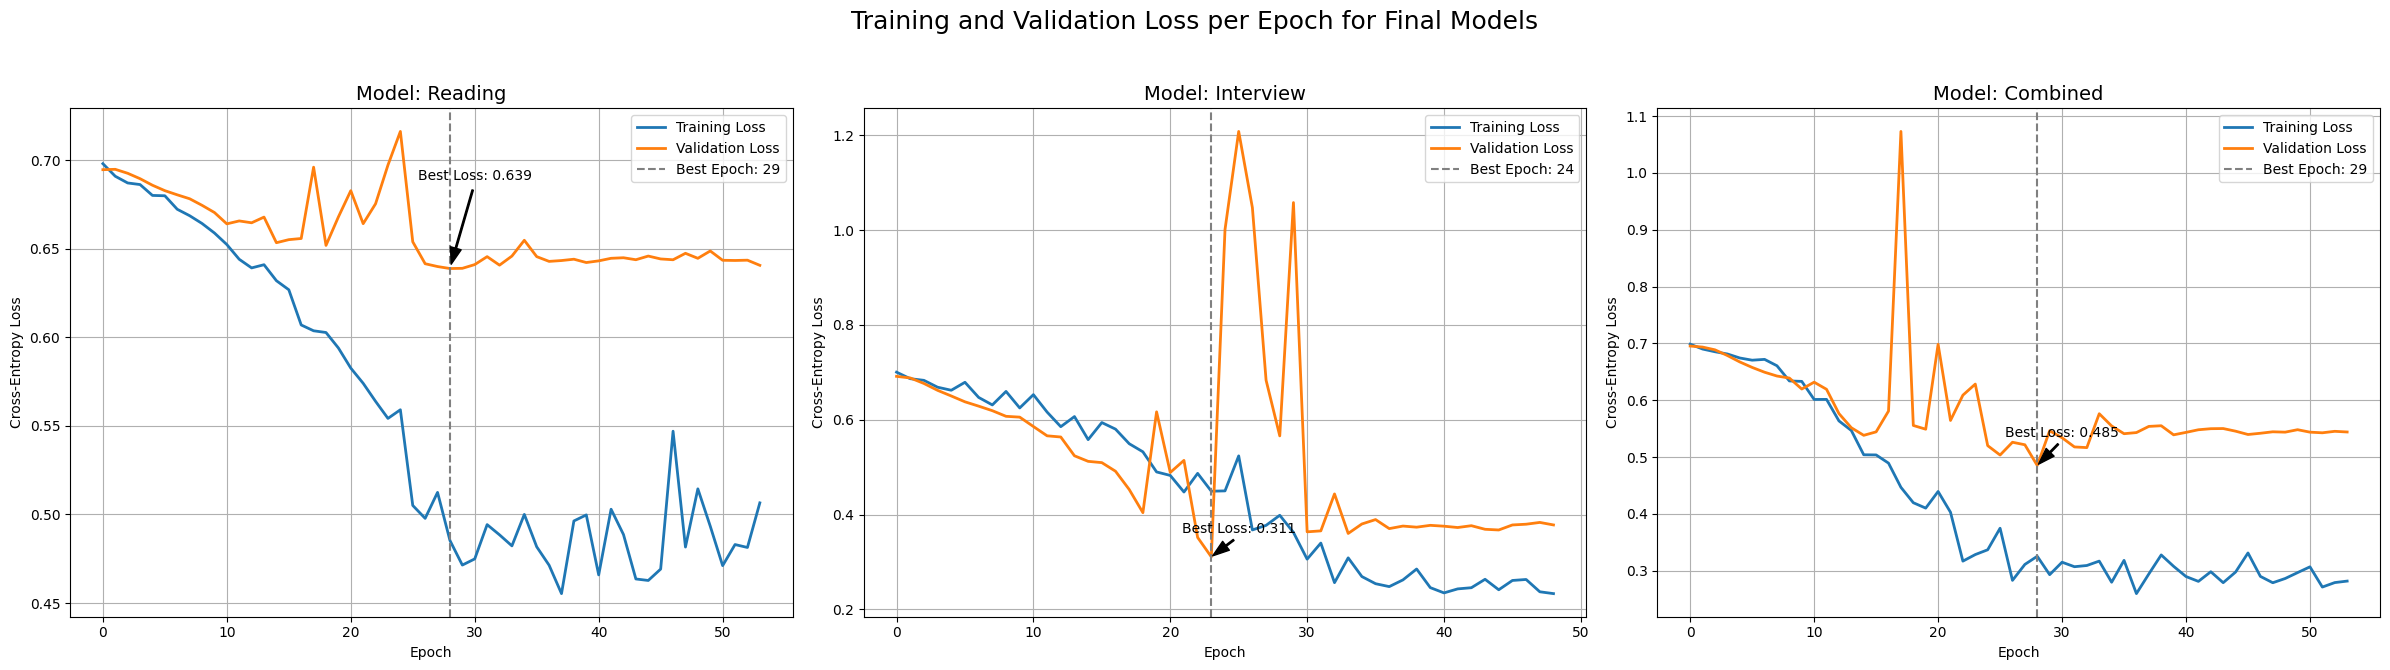

In [ ]:
import matplotlib.pyplot as plt
# Visualize Training and Validation Loss Curves from Saved Models

print("--- Generating Training/Validation Loss Curves for Final Models ---")

# Create a figure with 1 row and 3 columns for the side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=False)
fig.suptitle('Training and Validation Loss per Epoch for Final Models', fontsize=18)

# Loop through the three data types to find their saved models
for i, data_type in enumerate(['reading', 'interview', 'combined']):
    ax = axes[i]
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    # Load the history directly from the saved model file
    if os.path.exists(MODEL_SAVE_PATH):
        saved_data = torch.load(MODEL_SAVE_PATH)
        
        # Check if the history was saved in the file
        if 'train_loss_history' in saved_data and 'val_loss_history' in saved_data:
            train_history = saved_data['train_loss_history']
            val_history = saved_data['val_loss_history']
            
            # Plot the training and validation loss
            ax.plot(train_history, label='Training Loss', color='C0', lw=2)
            ax.plot(val_history, label='Validation Loss', color='C1', lw=2)
            
            # Find the epoch with the best validation loss to annotate the plot
            best_epoch = np.argmin(val_history)
            best_val_loss = np.min(val_history)
            
            # Add a vertical line and annotation to mark the best epoch
            ax.axvline(x=best_epoch, color='grey', linestyle='--', label=f'Best Epoch: {best_epoch + 1}')
            ax.annotate(f'Best Loss: {best_val_loss:.3f}', 
                        xy=(best_epoch, best_val_loss), 
                        xytext=(best_epoch + 2, best_val_loss + 0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                        ha='center')
            
            ax.set_title(f'Model: {data_type.title()}', fontsize=14)
            ax.legend()
        else:
            ax.set_title(f'Model: {data_type.title()}\n(History not found in file)')
    else:
        ax.set_title(f'Model: {data_type.title()}\n(Model file not found)')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cross-Entropy Loss')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Load all experiment results into one dictionary

# Load the SVM results you generated in notebook 03
SVM_RESULTS_PATH = '../data/Processed_Features/all_svm_results.pkl' 
if os.path.exists(SVM_RESULTS_PATH):
    with open(SVM_RESULTS_PATH, 'rb') as f:
        all_results = pickle.load(f)
else:
    print("Warning: SVM results file not found. Final comparison will only show DL models.")
    all_results = {}

# The 'tuned_dl_results' dictionary already exists in this notebook's memory
# from the previous cell. Add contents to master dictionary.
all_results.update(tuned_dl_results)

print(f"Successfully loaded a total of {len(all_results)} experiment results for final comparison.")

# Create and Display Summary Table
final_summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    final_summary_data.append({
        'Experiment': experiment_name,
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
        'Mean Accuracy': results_df['accuracy'].mean(),
        'Std Dev Accuracy': results_df['accuracy'].std()
    })

final_summary_df = pd.DataFrame(final_summary_data).set_index('Experiment')

print("\n--- Results Table for Nested k-fold Cross Validation ---")
display(final_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in final_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in final_summary_df.columns if 'Std Dev' in c], axis=0))

Successfully loaded a total of 3 experiment results for final comparison.

--- Results Table for Nested k-fold Cross Validation ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
wav2vec2_cnn_lstm_tuned_reading,0.700233,0.098512,0.779298,0.052024,0.703557,0.100217
wav2vec2_cnn_lstm_tuned_interview,0.769940,0.106447,0.865358,0.096245,0.771429,0.105247
wav2vec2_cnn_lstm_tuned_combined,0.778985,0.085707,0.847107,0.092551,0.780952,0.085866


In [ ]:
# Run Standard K-Fold Experiments for CNN-LSTM

from src.dl_cv_strategies import run_pytorch_standard_kfold_cv

# This dictionary will hold the best hyperparameters found from the nested CV runs
best_params_per_dataset = {}
for name in ['reading', 'interview', 'combined']:
    exp_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    if exp_name in tuned_dl_results:
        results_df = tuned_dl_results[exp_name]['results_df']
        best_params = results_df.loc[results_df['f1_score'].idxmax()]['best_params']
        best_params_per_dataset[name] = best_params

# Loop through the three datasets and run the standard k-fold experiment
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_standard_{name}'
    results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
    
    if name in best_params_per_dataset and not os.path.exists(results_save_path):
        print(f"\n--- Running STANDARD K-FOLD experiment: {experiment_name.upper()} ---")
        
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Capture histories and weights
        results_df, predictions, histories, weights = run_pytorch_standard_kfold_cv(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            hyperparams=best_params_per_dataset[name],
            epochs=100,
            patience=25,
            batch_size=BATCH_SIZE
        )
        
        # Save results, now including the histories and weights
        results_to_save = {
            'results_df': results_df, 
            'predictions': predictions, 
            'histories': histories, 
            'weights': weights # NEW
        }
        with open(results_save_path, 'wb') as f: pickle.dump(results_to_save, f)
        print(f"Results saved to {results_save_path}")
        all_results[experiment_name] = results_to_save
    else:
        print(f"\nSkipping or loading pre-computed results for {experiment_name.upper()}")
        if os.path.exists(results_save_path) and experiment_name not in all_results:
             with open(results_save_path, 'rb') as f: all_results[experiment_name] = pickle.load(f)

print("\n--- All Standard K-Fold DL experiments are now complete! ---")


Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_READING

Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_INTERVIEW

Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_COMBINED

--- All Standard K-Fold DL experiments are now complete! ---


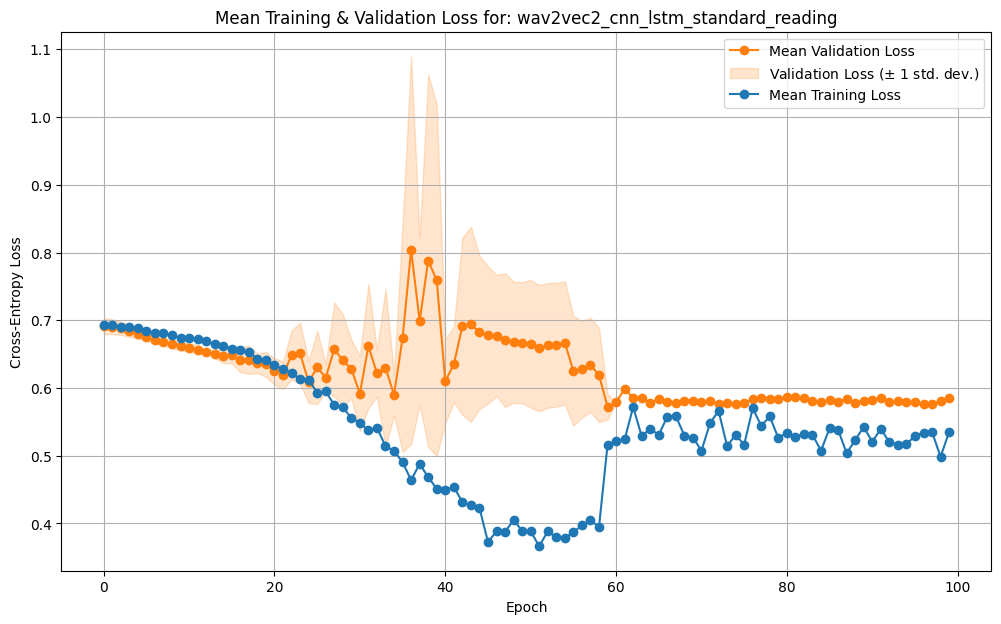

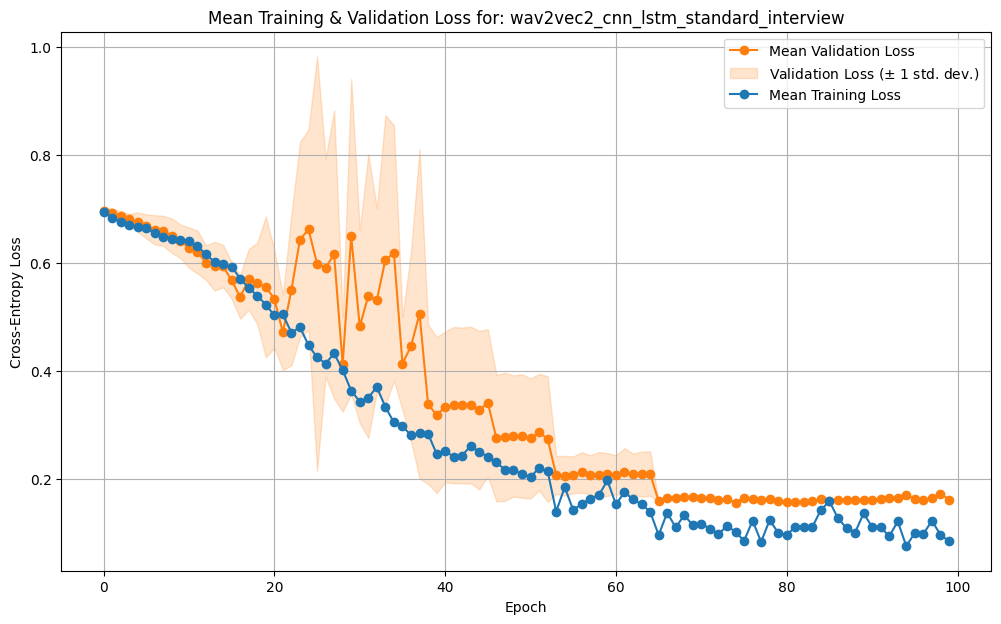

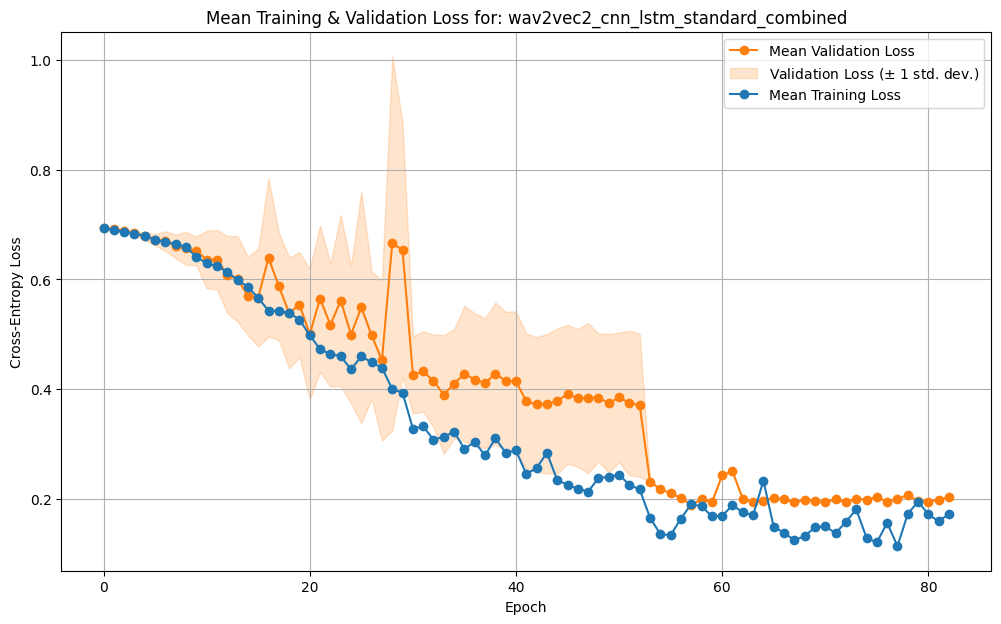

In [ ]:
# Visualize Loss Curves for Standard K-Fold DL Experiments 

# This cell plots the mean and std dev of loss curves across the 5 folds for each experiment

for name in ['reading', 'interview', 'combined']:
    experiment_name = f'wav2vec2_cnn_lstm_standard_{name}'
    if experiment_name in all_results and 'histories' in all_results[experiment_name]:
        histories = all_results[experiment_name]['histories']
        
        plt.figure(figsize=(12, 7))
        
        # Process and plot for validation loss
        val_losses = [h['val'] for h in histories]
        # Pad shorter sequences with NaN to average correctly
        max_len = max(len(l) for l in val_losses)
        val_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in val_losses])
        
        mean_val_loss = np.nanmean(val_losses_padded, axis=0)
        std_val_loss = np.nanstd(val_losses_padded, axis=0)
        
        epochs = np.arange(len(mean_val_loss))
        
        plt.plot(epochs, mean_val_loss, 'o-', color='C1', label='Mean Validation Loss')
        plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss,
                         color='C1', alpha=0.2, label=r'Validation Loss ($\pm$ 1 std. dev.)')

        # Process and plot for training loss 
        train_losses = [h['train'] for h in histories]
        train_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in train_losses])
        mean_train_loss = np.nanmean(train_losses_padded, axis=0)
        plt.plot(epochs, mean_train_loss, 'o-', color='C0', label='Mean Training Loss')
        
        plt.title(f'Mean Training & Validation Loss for: {experiment_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
# Summary Table

# Define the names of the 6 DL experiments
dl_experiment_names = [
    'wav2vec2_cnn_lstm_standard_reading',
    'wav2vec2_cnn_lstm_tuned_reading',
    'wav2vec2_cnn_lstm_standard_interview',
    'wav2vec2_cnn_lstm_tuned_interview',
    'wav2vec2_cnn_lstm_standard_combined',
    'wav2vec2_cnn_lstm_tuned_combined'
]

# Filter the main 'all_results' dictionary
dl_summary_data = []
for name in dl_experiment_names:
    if name in all_results:
        results_df = all_results[name]['results_df']
        dl_summary_data.append({
            'Experiment': name,
            'Mean F1-Score': results_df['f1_score'].mean(),
            'Std Dev F1-Score': results_df['f1_score'].std(),
            'Mean AUC': results_df['auc'].mean(),
            'Std Dev AUC': results_df['auc'].std(),
        })

dl_summary_df = pd.DataFrame(dl_summary_data).set_index('Experiment')

print("\n--- Final Performance Summary for All CNN-LSTM Experiments ---")
display(dl_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in dl_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in dl_summary_df.columns if 'Std Dev' in c], axis=0)
                          .format("{:.3f}"))


--- Final Performance Summary for All CNN-LSTM Experiments ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC
Experiment,,,,
wav2vec2_cnn_lstm_standard_reading,0.629,0.134,0.741,0.096
wav2vec2_cnn_lstm_tuned_reading,0.700,0.099,0.779,0.052
wav2vec2_cnn_lstm_standard_interview,0.740,0.088,0.814,0.072
wav2vec2_cnn_lstm_tuned_interview,0.770,0.106,0.865,0.096
wav2vec2_cnn_lstm_standard_combined,0.607,0.157,0.777,0.090
wav2vec2_cnn_lstm_tuned_combined,0.779,0.086,0.847,0.093


In [ ]:
# Visualize Feature Importance Stability for DL Models

print("--- Generating Feature Importance Stability Plots for DL Models ---")

for name in ['reading', 'interview', 'combined']:
    exp_name_std = f'wav2vec2_cnn_lstm_standard_{name}'
    
    if exp_name_std in all_results and 'weights' in all_results[exp_name_std]:
        # Get the weights (shape: 5 folds x 768 features)
        weights = all_results[exp_name_std]['weights']
        
        # Calculate the mean importance and the stability (how many folds it was important in)
        mean_importance = np.mean(weights, axis=0)
        
        # Measure stability by how often a feature is in the top N
        top_n = 50 # Consider top 50 features as "selected"
        
        # Get the indices of the top N features for each fold
        top_indices_per_fold = np.argsort(weights, axis=1)[:, -top_n:]
        
        # Count the frequency of each feature index being in the top N
        feature_stability_counts = Counter(top_indices_per_fold.flatten())
        
        # Create a DataFrame for plotting
        stability_df = pd.DataFrame(feature_stability_counts.items(), columns=['feature_index', 'count'])
        stability_df = stability_df.sort_values(by='count', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')
        plt.title(f'Top 20 Most Stable Feature Dimensions for: {exp_name_std}')
        plt.xlabel('Number of Folds Selected In (out of 5)')
        plt.ylabel('Wav2Vec2 Feature Dimension Index')
        plt.tight_layout()
        plt.show()

--- Generating Feature Importance Stability Plots for DL Models ---
